#### Small collocation example

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

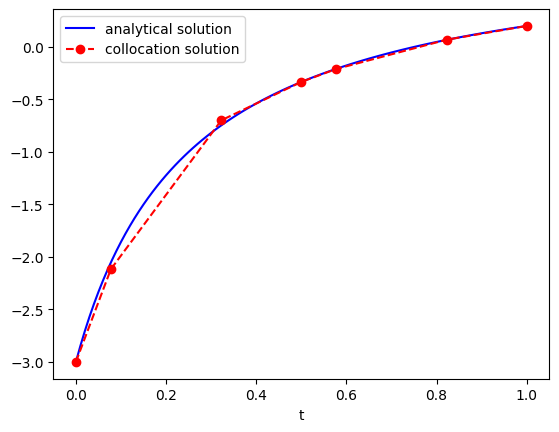

In [1]:
import pyomo.environ as pyo

numcollocation = 4
numfinelems = 2

model = m = pyo.ConcreteModel()
m.colloc = pyo.RangeSet(0,numcollocation-1)
m.fe = pyo.RangeSet(0,numfinelems-1)
m.h = pyo.Param(initialize=1.0/numfinelems)

m.z = pyo.Var(m.fe,m.colloc)
m.dzdt = pyo.Var(m.fe,m.colloc)
m.time = pyo.Var(m.fe,m.colloc)

# Collocation matrix for Radau points [0, 0.155051, 0.644949, 1]
adot=[
[-9.000001008080126, -4.1393887736243791, 1.7393879671602779, -3.0000002520200333],
[10.048810106494384, 3.2247461916839306, -3.5678400771209411, 5.5319724150606273],
[-1.3821424037453669, 1.1678398419022438, 0.77525464838285485, -7.5319723310539404],
[0.33333330533110994, -0.25319725996179565, 1.0531974615778044, 5.000000168013341],
]

m.obj = pyo.Objective(expr=1) # Dummy Objective

def _zdot(m, i, j):
    return m.dzdt[i,j] == m.z[i,j]**2 - 2*m.z[i,j] +1
m.zdot = pyo.Constraint(m.fe,m.colloc,rule=_zdot)

# Collocation Equations
def _colloc_eq(m,i,j):
    if j == 0:
        return pyo.Constraint.Skip
    return m.h*(m.dzdt[i,j]) == sum(m.z[i,k]*adot[k][j] for k in range(0,numcollocation))
m.colloc_eq = pyo.Constraint(m.fe,m.colloc,rule=_colloc_eq)

def _colloc_eq_t(m,i,j):
    if j == 0:
        return pyo.Constraint.Skip
    return m.h == sum(m.time[i,k]*adot[k][j] for k in range(0,numcollocation))
m.colloc_eq_t = pyo.Constraint(m.fe,m.colloc,rule=_colloc_eq_t)


# Continuity Equations
def _cont_z(m,i):
    if i == 0:
        return pyo.Constraint.Skip
    return m.z[i,0] == m.z[i-1,numcollocation-1]
m.cont_z = pyo.Constraint(m.fe,rule=_cont_z)

def _cont_t(m,i):
    if i == 0:
        return pyo.Constraint.Skip
    return m.time[i,0] == m.time[i-1,numcollocation-1]
m.cont_t = pyo.Constraint(m.fe,rule=_cont_t)

# Initial Conditions
def _init_con(m):
    return m.z[0,0] == -3
m.init_con = pyo.Constraint(rule=_init_con)

def _init_con_t(m):
    return m.time[0,0] == 0
m.init_con_t = pyo.Constraint(rule=_init_con_t)

solver = pyo.SolverFactory('ipopt')
solver.solve(m,tee=True)

import matplotlib.pyplot as plt

analytical_t = [0.01*i for i in range(0,101)]
analytical_z = [(4*t-3)/(4*t+1) for t in analytical_t]

findiff_t = []
findiff_z = []

for i in range(0,numfinelems):
    for j in range(0,numcollocation):
        if i != 0 and j == 0:
            continue
        findiff_t.append(pyo.value(m.time[i,j]))
        findiff_z.append(pyo.value(m.z[i,j]))

plt.plot(analytical_t,analytical_z,'b',label='analytical solution')
plt.plot(findiff_t,findiff_z,'ro--',label='collocation solution')
plt.legend(loc='best')
plt.xlabel("t")
plt.show()